In [33]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
with sqlite3.connect("../laliga.sqlite") as con:
    df=pd.read_sql_query("SELECT * FROM Matches",con)
    dr=pd.read_sql_query("SELECT * FROM Predictions",con)

df = df.dropna(subset=['score'])

In [35]:
df["score_home_team"] = df["score"].str.split(":").str[0].astype(float)
df["score_away_team"] = df["score"].str.split(":").str[1].astype(float)
df["goal_difference"] = df["score_home_team"] - df["score_away_team"]

df["match_result"] = np.where(df['score_home_team'] > df['score_away_team'], '1', np.where(df['score_home_team'] < df['score_away_team'], '2', 'X'))

In [36]:
def func_home_wins(data):
    return (data[data == '1']).count()

def func_away_wins(data):
    return (data[data == '2']).count()

def func_tie(data):
    return (data[data == 'X']).count()

df_class_home = df.groupby(['division', 'season', 'home_team']).agg(
    GF=pd.NamedAgg(column='score_home_team', aggfunc='sum'),
    GA=pd.NamedAgg(column='score_away_team', aggfunc='sum'),
    W=pd.NamedAgg(column='match_result', aggfunc=func_home_wins),
    L=pd.NamedAgg(column='match_result', aggfunc=func_away_wins),
    T=pd.NamedAgg(column='match_result', aggfunc=func_tie)
).reset_index()

df_class_away = df.groupby(['division', 'season', 'away_team']).agg(
    GF=pd.NamedAgg(column='score_away_team', aggfunc='sum'),
    GA=pd.NamedAgg(column='score_home_team', aggfunc='sum'),
    W=pd.NamedAgg(column='match_result', aggfunc=func_away_wins),
    L=pd.NamedAgg(column='match_result', aggfunc=func_home_wins),
    T=pd.NamedAgg(column='match_result', aggfunc=func_tie)
).reset_index()

df_class_away.rename(columns={'away_team': 'team'}, inplace=True)
df_class_home.rename(columns={'home_team': 'team'}, inplace=True)

df_classification = df_class_away.merge(df_class_home, how='outer')
df_classification = df_classification.groupby(['season', 'team', 'division']).sum().reset_index()
# df_classification['GF'] = df_classification['GF'].shift(1)

df_classification['GD'] = df_classification['GF'] - df_classification['GA']
df_classification['Pts'] = (df_classification['W']) * 3 + df_classification['T']

df_classification['year_of_start'] = df_classification['season'].str.split("-").str[0].astype(int)

df_classification_ordered = df_classification.sort_values(by=['year_of_start'], ascending=False)
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division'], ascending=[False, True])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'Pts'], ascending=[False, True, False])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'Pts', 'GD'], ascending=[False, True, False, False])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'Pts', 'GD', 'GF'], ascending=[False, True, False, False, False])

df_classification_ordered = df_classification_ordered.reset_index(drop=True)
df_classification_ordered['rank'] = df_classification_ordered.groupby(['year_of_start', 'division']).cumcount() + 1

df_classification_1_div = df_classification_ordered[df_classification_ordered['division']==1]
df_classification_2_div = df_classification_ordered[df_classification_ordered['division']==2]
num_teams_1_div = df_classification_1_div.groupby('season')['rank'].max().reset_index()

merged_df = df_classification_2_div.merge(num_teams_1_div, on='season')
merged_df['rank'] = merged_df['rank_x'] + merged_df['rank_y']
merged_df = merged_df.drop(columns={'rank_x','rank_y'})
df_classification_ordered_next = merged_df.merge(df_classification_1_div,how='outer')

df_classification_ordered_next = df_classification_ordered_next.sort_values(by=['year_of_start', 'division', 'Pts', 'GD', 'GF'], ascending=[False, True, False, False, False])
df_classification_ordered_next['delayed_rank'] = df_classification_ordered_next.groupby(['team'])['rank'].shift(-1)

df_with_rank = df_classification_ordered_next[['season','division','team','delayed_rank']]


In [37]:
df_useful = df[['season','division','home_team','match_result','away_team']]

home_team_rank = df_useful.merge(df_with_rank, left_on=['season','division', 'home_team'], right_on=['season','division', 'team'], how='left')
home_team_rank.rename(columns={'delayed_rank': 'home_team_rank'}, inplace=True)
home_team_rank.drop(columns=['team'], inplace=True)

away_team_rank = df_useful.merge(df_with_rank, left_on=['season', 'division', 'away_team'], right_on=['season','division', 'team'], how='left')
away_team_rank.rename(columns={'delayed_rank': 'away_team_rank'}, inplace=True)
away_team_rank.drop(columns=['team'], inplace=True)

df_new = away_team_rank.merge(home_team_rank, on=['season', 'division', 'home_team','away_team'], how='left')

df_new.rename(columns={'match_result_x': 'match_result'},inplace=True)

df_to_train = df_new[['season','home_team','away_team','home_team_rank','away_team_rank','match_result']]
df_to_train = df_to_train.fillna(0)

In [38]:
features = ['away_team_rank','home_team_rank']
target = ["match_result"]

In [39]:
df_train = df_to_train[(df_to_train['season'] > '2000-2001') & (df_to_train['season'] < '2020-2021')]
x_train = df_train[features]
y_train = df_train[target]

df_test = df_to_train[df_to_train['season']=='2020-2021']
x_test = df_test[features]
y_test = df_test[target]

In [40]:
clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)
clf_y_pred = clf.predict(x_test)

results_df = x_test.copy()
results_df = df_test.copy()
results_df["match_result_prediction"] = clf_y_pred # el nome haura de ser pred per a que funcioni despres 

model_is_correct = (results_df["match_result_prediction"] == results_df["match_result"]).sum()
total_tries = len(results_df)

print(model_is_correct/total_tries*100)

results_df.tail(40)

c:\Users\usuario\OneDrive\Escritorio\quiniela2\la-quiniela\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


46.67458432304038


,season,home_team,away_team,home_team_rank,away_team_rank,match_result,match_result_prediction
48266,2020-2021,UD Las Palmas,Real Zaragoza,29.0,23.0,2,1
48267,2020-2021,CE Sabadell,CD Tenerife,41.0,32.0,2,1
48268,2020-2021,CF Fuenlabrada,Rayo Vallecano,28.0,27.0,2,1
48269,2020-2021,RCD Mallorca,Alcorcón,19.0,30.0,1,1
48270,2020-2021,CD Leganés,UD Logroñés,18.0,0.0,1,1
48271,2020-2021,Real Oviedo,Málaga CF,35.0,34.0,1,1
48272,2020-2021,Girona,Sporting Gijón,25.0,33.0,1,1
48273,2020-2021,FC Cartagena,UD Almería,40.0,24.0,1,1
48274,2020-2021,Albacete,CD Lugo,36.0,37.0,X,1
48275,2020-2021,Ponferradina,Espanyol,38.0,20.0,2,X


In [46]:
#performance for different situations
seasons=['1940-1941','1950-1951','1960-1961','1970-1971','1980-1981','1990-1991','2000-2001','2010-2011']
perf=[]
home_win=[]
for i in range(len(seasons)):
    df_train = df_to_train[(df_to_train['season'] > seasons[i]) & (df_to_train['season'] < '2020-2021')]
    x_train = df_train[features]
    y_train = df_train[target]

    df_test = df_to_train[df_to_train['season']=='2020-2021']
    x_test = df_test[features]
    y_test = df_test[target]
    clf = GradientBoostingClassifier()
    clf.fit(x_train, y_train)
    clf_y_pred = clf.predict(x_test)

    results_df = x_test.copy()
    results_df = df_test.copy()
    results_df["match_result_prediction"] = clf_y_pred # el nome haura de ser pred per a que funcioni despres 
    home_wins=(results_df['match_result_prediction']=='1').sum()
    model_is_correct = (results_df["match_result_prediction"] == results_df["match_result"]).sum()
    total_tries = len(results_df)
    
    print(home_wins/total_tries*100)
    home_win.append(home_wins/total_tries*100)

    perf.append(model_is_correct/total_tries*100)
    del df_train
    del x_train
    del y_train
    del df_test
    del x_test
    del y_test
    del clf 
    del clf_y_pred
    del results_df
    model_is_correct=0
    total_tries=0
    home_wins=0


c:\Users\usuario\OneDrive\Escritorio\quiniela2\la-quiniela\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


95.36817102137766


c:\Users\usuario\OneDrive\Escritorio\quiniela2\la-quiniela\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


94.77434679334917


c:\Users\usuario\OneDrive\Escritorio\quiniela2\la-quiniela\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


94.77434679334917


c:\Users\usuario\OneDrive\Escritorio\quiniela2\la-quiniela\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


94.41805225653206


c:\Users\usuario\OneDrive\Escritorio\quiniela2\la-quiniela\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


92.63657957244655


c:\Users\usuario\OneDrive\Escritorio\quiniela2\la-quiniela\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


91.92399049881234


c:\Users\usuario\OneDrive\Escritorio\quiniela2\la-quiniela\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


88.00475059382423


c:\Users\usuario\OneDrive\Escritorio\quiniela2\la-quiniela\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


83.1353919239905


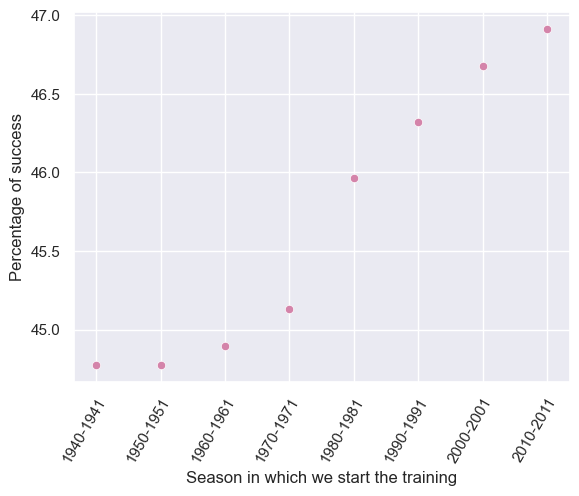

In [42]:
sns.set_theme()
sns.scatterplot(x=seasons,y=perf,color='#d484aa')
plt.xticks(rotation=60, ha='right',rotation_mode='anchor')
plt.ylabel('Percentage of success')
plt.xlabel('Season in which we start the training')
plt.show()

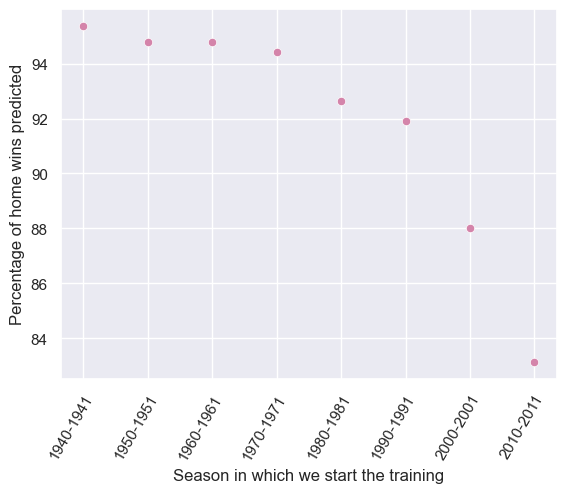

In [47]:
sns.set_theme()
sns.scatterplot(x=seasons,y=home_win,color='#d484aa')
plt.xticks(rotation=60, ha='right',rotation_mode='anchor')
plt.ylabel('Percentage of home wins predicted')
plt.xlabel('Season in which we start the training')
plt.show()
